# CSE 152A Fall 2022 – Assignment 1


- Assignment Published On: **Wed, Oct 05, 2022**

- Due On: **Fri, Oct 14, 2022 11:59 PM (Pacific Time)**

## Instructions

Please answer the questions below using Python in the attached Jupyter notebook and follow the guidelines below:
 
- This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy posted on lecture slides.

- All the solutions must be written in this Jupyter notebook.

- After finishing the assignment in the notebook, please export the notebook as a PDF and submit both the notebook and the PDF (i.e. the `.ipynb` and the `.pdf` files) on Gradescope.

- You may use basic algebra packages (e.g. `NumPy`, `SciPy`, etc) but you are not allowed to use open source codes that directly solve the problems. Feel free to ask the instructor and the teaching assistants if you are unsure about the packages to use.

- It is highly recommended that you begin working on this assignment early.

**Late Policy:** Assignments submitted late will receive a 15% grade reduction for each 12 hours late (that is, 30% per day).

## Problem 1: Photometric Stereo [20 pts]

The goal of this problem is to implement Lambertian photometric stereo. 

Note that the albedo is unknown and non-constant in the images you will use.

As input, your program should take in multiple images along with the light source direction for each image.

### Data
You will use synthetic images as data. These images are stored in `.pickle` files which were graciously provided by Satya Mallick. Each `.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.
  
You will find all the data for this part in `synthetic_data.pickle`. 

Keys: dict_keys(['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3'])
Image:


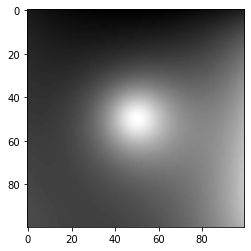

Light source direction: [[0 0 1]]


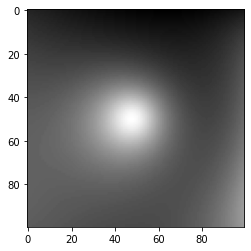

Light source direction: [[0.2 0.  1. ]]


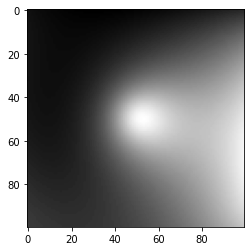

Light source direction: [[-0.2  0.   1. ]]


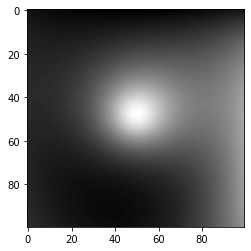

Light source direction: [[0.  0.2 1. ]]


In [223]:
## Example: How to read and access data from a pickle

import pickle
import matplotlib.pyplot as plt

pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: " + str(data.keys()))

# To access the value of an entity, refer it by its key.
print("Image:")
plt.imshow(data["im1"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l1"]))

plt.imshow(data["im2"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l2"]))

plt.imshow(data["im3"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l3"]))

plt.imshow(data["im4"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l4"]))

### 1(a) Photometric Stereo [8 pts]
  
Implement the photometric stereo technique described in the lecture. Your program should have two parts:
<ul>
<li>Read in the images and corresponding light source directions, and estimate the surface normals and albedo map. </li>
<li>Reconstruct the depth map from the surface with the implementation of the Horn integration technique given below in `horn_integrate` function. Note that you will typically want to run the `horn_integrate` function with 10000 - 100000 iterations, meaning it will take a while.</li></ul>

In [224]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

In [225]:
def photometric_stereo(images, lights, mask, horn_niter=25000):
    
    """mask is an optional parameter which you are encouraged to use.
    It can be used e.g. to ignore the background when integrating the normals.
    It should be created by converting the images to grayscale and thresholding
    (only using locations for which the pixel value is above some threshold).
    
    The choice of threshold is something you can experiment with,
    but in practice something like 0.05 tends to work well.
    """

    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)
    
    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))

    H_horn = np.ones(images[0].shape)
    
    """ ==========
    YOUR CODE HERE
    ========== """
    b = numpy.linalg.inv(lights) * images
    albedo = numpy.linalg.norm(b);
    
    for x in range(len(normals)):
        normals = b/np.linalg.norm(b);
    
    gx1 = normals[0]/normals[3]
    gy1 = normals[2]/normals[3]
    H_horn = horn_integrate(gx1, gy1, mask, horn_niter);
    
    return albedo, normals, H_horn

### 1(b) Display outputs using `im1`, `im2` and `im4` [6 Points]
  
<ul>
<li>The estimated albedo map.</li>

<li>The estimated surface normals by showing both
    <ul>
        <li>Needle map, and</li>
        <li>Three images showing components of surface normal.</li>
    </ul>
<li>A wireframe of depth map.</li>
</ul>

An example of outputs is shown in the figure below.
  

![Problem1%20example.png](Problem1%20example.png)

In [226]:
from mpl_toolkits.mplot3d import Axes3D


# --------------------------------------------------------------------------
# The following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout. You are also free to change the function
# however you wish; just make sure you get all of the required outputs.
# --------------------------------------------------------------------------

def visualize(albedo, normals, horn_depth):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = horn_depth[::stride,::stride].T
    #changed from update
    NX = -normals[..., 0][::stride,::stride].T
    NY = -normals[..., 1][::stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    plt.quiver(X,Y,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map

    H = horn_depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

In [227]:
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, horn_depth = photometric_stereo(images, lights, mask)

visualize(albedo, normals, horn_depth)

ValueError: operands could not be broadcast together with shapes (3,3) (3,100,100) 

### Display outputs using all four images (most accurate result) [6 points]

<ul>
<li>The estimated albedo map.</li>

<li>The estimated surface normals by showing both
    <ul>
        <li>Needle map, and</li>
        <li>Three images showing components of surface normal.</li>
    </ul>
<li>A wireframe of depth map.</li>
</ul>

In [ ]:
""" ==========
YOUR CODE HERE
========== """
visualize(albedo, normals, horn_depth)


## Problem 2: Image Rendering [20 points]


In this exercise, we will render the image of a face with two different point light sources using a Lambertian reflectance model. We will use two albedo maps, one uniform and one that is more realistic. The face heightmap, the light sources, and the two albedo are given in facedata.npy for Python (each row of the `lightsource` variable encode a light location). The data from facedata.npy is already provided to you.

Note: Please make good use out of subplot to display related image next to eachother.

$\textbf{2(a) Plot the face in 2-D [2 pts]}$

Plot both albedo maps using imshow. Explain what you see.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

# Load facedata.npy as ndarray
face_data = np.load('facedata.npy',encoding='latin1', allow_pickle=True)

# Load albedo matrix 
albedo = face_data.item().get('albedo')

# Load uniform albedo matrix
uniform_albedo = face_data.item().get('uniform_albedo')

# Load heightmap 
heightmap = face_data.item().get('heightmap')

# Load light source
light_source = face_data.item().get('lightsource')



In [ ]:
# Plot the face in 2-D (plot both albedo maps using imshow)
""" ==========
YOUR CODE HERE
========== """

plt.imshow(albedo)
plt.imshow(uniform_albedo)
#plt.imshow(heightmap)
#plt.imshow(light_source)

# I see a human face outline

$\textbf{2(b) Plot the face in 3-D [2 pts]}$

Using both the heightmap and the albedo, plot the face using plot\_surface. Do this for both albedos. Explain what you see.


In [ ]:
# Plot the face in 3-D 
# (Using the heightmap & albedo plot the faces using plot_surface)
""" ==========
YOUR CODE HERE
========== """


# Axes3D.plot_surface(albedo)
# Axes3D.plot_surface(uniform_albedo)
# Axes3D.plot_surface(heightmap)

X, Y, _ = np.meshgrid(np.arange(0,np.shape(albedo)[0], 1),
                          np.arange(0,np.shape(albedo)[1], 1),
                          np.arange(1))
X = X[..., 0]
Y = Y[..., 0]
Z = heightmap[::1,::1].T

# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(projection='3d')


fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.plot_surface(X,Y,Z, facecolors=plt.cm.gray(albedo.T))
# plt.show()


$\textbf{2(c) Surface normals [8 pts]}$

Calculate the surface normals and display them as a quiver plot using quiver in matplotlib.pyplot in Python. Recall that the surface normals are given by 
\begin{eqnarray}
[-\frac{\delta f}{\delta x}, -\frac{\delta f}{\delta y}, 1].
\end{eqnarray}
Also, recall, that each normal vector should be normalized to unit length.

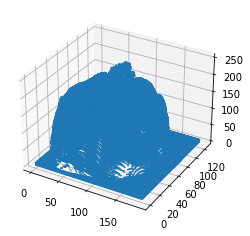

In [244]:
# Compute and plot the surface normals
# (make sure that the normal vector is normalized to unit length)
""" ==========
YOUR CODE HERE
========== """
import scipy
import numpy as np

f = np.array([[0,0,0],[1/2, 0,-1/2],[0,0,0]])
g = np.array([[0,1/2,0],[0, 0,0],[0,-1/2,0]])

fx = scipy.signal.convolve(heightmap, f, mode='same')
fy = scipy.signal.convolve(heightmap,g, mode='same')
third_col = np.ones(albedo.shape)
normals = np.dstack((-fx,-fy,third_col))

#normalization
for i in range(normals.shape[0]):
    for j in range(normals.shape[1]):
        normals[i,j,:] = [-fx[i,j],-fy[i,j],1]/np.linalg.norm([-fx[i,j],-fy[i,j],1])

X, Y, _ = np.meshgrid(np.arange(0,np.shape(albedo)[0]),
                          np.arange(0,np.shape(albedo)[1]),
                          np.arange(1))
X = X[..., 0]
Y = Y[..., 0]
Z = heightmap[::1,::1].T
#changed from update
NX = -normals[..., 0][::1,::-1].T
NY = -normals[..., 1][::-1,::1].T
NZ = normals[..., 2][::1,::1].T
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# print(len(Z), len(Z[0]))
plt.quiver(X,Y,Z,NX,NY,NZ, length=10)
plt.show()
# plt.quiver(X, Y, surface_normal)



$\textbf{2(d) Render images [8 pts]}$

For each of the two albedos, render three images. One for each of the two light sources, and one for both light-sources combined. Display these in a $2 \times 3$ subplot figure with titles. Recall that the general image formation equation is given by
\begin{eqnarray}
I = a(x,y) \hat{\boldsymbol{\mathrm{n}}}(x,y)^\top \hat{\boldsymbol{\mathrm{s}}}(x,y) s_0
\end{eqnarray}
where $a(x,y)$ is the albedo for pixel $(x, y)$, $\hat{n}(x,y)$ is the corresponding surface normal, $\hat{s}(x,y)$ the light source direction, $s_0$ the light source intensity. Let the light source intensity be $1$ and make the `distant light source assumption'.
Use imshow with appropriate keyword arguments .

In [258]:
# Render Images

def lambertian(normals, light, albedo, intensity, mask):
    """ ==========
    YOUR CODE HERE
    ========== """
    light_2 = light[0] + light[1]/np.linalg.norm(light[0] + light[1]) 
    im0 = np.zeros((mask[0],mask[1],3),dtype = int)
    im1 = np.zeros((mask[0],mask[1],3),dtype = int)
    im2 = np.zeros((mask[0],mask[1],3),dtype = int)
    
    for i in range(mask[0]):
        for j in range(mask[1]):
            im0[i,j] = albedo[i,j] * np.matmul(normals[i,j],light[0]) * intensity 
            im1[i,j] = albedo[i,j] * np.matmul(normals[i,j],light[1]) * intensity 
            im2[i,j] = albedo[i,j] * np.matmul(normals[i,j],light_2) * intensity
            
    figure = plt.figure()
    ax1 = figure.add_subplot(131) 
    ax1.set_title("light1") 
    ax1.imshow(im0)
    
    ax2 = figure.add_subplot(132) 
    ax2.set_title('light2') 
    ax2.imshow(im1)
    
    ax3 = figure.add_subplot(133) 
    ax3.set_title('combine3') 
    ax3.imshow(im2)
    plt.show()

    pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


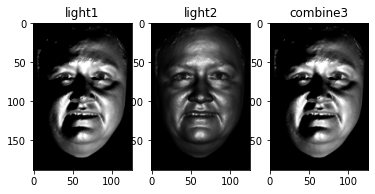

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


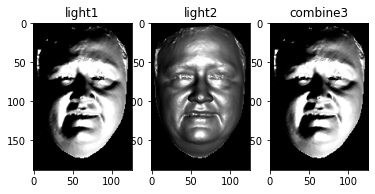

In [260]:
# For each of the two albedos, render three images. 
# One for each of the two light sources, and one for both light-sources combined.
""" ==========
YOUR CODE HERE
========== """
intensity = 1

mask = heightmap.shape

lambertian(normals, light_source, albedo, intensity, mask)
lambertian(normals, light_source, uniform_albedo, intensity, mask)

## Problem 3: Homogeneous Coordinates and Vanishing Points [20 points]
  
In class, we discussed the concept of homogeneous coordinates. In this example, we will confine ourselves to the real 2D plane. A point $(x, y)^\top$ on the real 2D plane can be represented in homogeneous coordinates by a 3-vector $(wx, wy, w)^\top$, where $w \neq 0$ is any real number. All values of $w \neq 0$ represent the same 2D point. Dividing out the third coordinate of a  homogeneous point $(x, y, z)$ converts it back to its 2D equivalent: $\left( \displaystyle\frac{x}{z}, \displaystyle\frac{y}{z} \right)^\top$.

Consider a line in the 2D plane, whose equation is given by $ax + by + c = 0$. This can equivalently be written as $\textbf{l}^\top \textbf{x} = 0$, where $\textbf{l} = (a, b, c)^\top$ and $\textbf{x} = (x, y, 1)^\top$. Noticing that $\textbf{x}$ is a homogeneous representation of $(x, y)^\top$, we define $\textbf{l}$ as a homogeneous representation of the line $ax + by + c = 0$. Note that the line $(ka)x + (kb)y + (kc) = 0$ for $k \neq 0$ is the same as the line $ax + by + c = 0$, so the homogeneous representation of the line $ax + by + c = 0$ can be equivalently given by $(a, b, c)^\top$ or $(ka, kb, kc)^\top$ for any $k \neq 0$.

All points $(x, y)$ that lie on the line $ax + by + c = 0$ satisfy the equation $\textbf{l}^\top \textbf{x} = 0$, thus, we can say that a condition for a homogeneous point $\textbf{x}$ to lie on the homogeneous line $\textbf{l}$ is that their dot product is zero, that is, $\textbf{l}^\top \textbf{x} = 0$. We note this down as a fact:
  
<b>Fact 1:</b> A point $\textbf{x}$ in homogeneous coordinates lies on the homogeneous line $\textbf{l}$ if and only if
$$
\textbf{x}^\top \textbf{l} = \textbf{l}^\top \textbf{x} = 0
$$

<!--   <div style="text-align: right"><b>[1 Point]</b></div> -->
Now let us solve a few simple examples:

<ul>
    <li><b>3(a)</b> Give at least two homogeneous representations for the point $(3, 5)^\top$ on the 2D plane, one with $w > 0$ and one with $w < 0$. <div style="text-align: right"><b>[1 Point]</b></div></li>
    

In [ ]:
(6, 10, 2)^T
(-6, -10, -2)^T

<ul>
<li><b>3(b)</b> What is the equation of the line passing through the points $(1, 1)^\top$ and $(-1, 3)^\top$ [in the usual Cartesian coordinates]? Now write down a 3-vector that is a homogeneous representation for this line. <div style="text-align: right"><b>[2 Points]</b></div></li>
</ul>


In [ ]:
1a+1b + c =0
-a+3b+c =0

1 = m+b
3 = -m+(1-m) --> 2 = -2m ---> m=-1, b =2
by = -ax-c
Answer: (1,1,-2)

We will now move on to consider the intersection of two lines. We make the claim that: "The (homogeneous) point of intersection, $\textbf{x}$, of two homogeneous lines $\textbf{l}_1$ and $\textbf{l}_2$ is
$\textbf{x} = \textbf{l}_1 \times \textbf{l}_2$, where $\times$ stands for the vector (or cross) product". 

<ul>
    <li><b>3(c)</b> In plain English, how will you express the condition a point must satisfy to lie at the intersection of two lines? Armed with this simple condition, and using <b>Fact 1</b>, can you briefly explain why $\textbf{l}_1 \times \textbf{l}_2$ must lie at the intersection of lines $\textbf{l}_1$ and $\textbf{l}_2$? <div style="text-align: right"><b>[5 Points]</b></div></li>
</ul>

In [ ]:
The condition that a point must satisfy to lie at the intersection of two lines is that it lies on both of the
lines. Fact 1 tells us that, for a point to lie to the line l, its dot product with the line l must be zero. 
(l1×l2)*l1 = 0
(l1×l2)*l2 = 0

In the following, we will use the above stated claim for the intersection of two lines.
  
<ul>
    <li><b>3(d)</b> Consider the two lines $x + y - 5 = 0$ and $4x - 5y + 7 = 0$. Use the claim in question <b>3(c)</b> to find their intersection in homogeneous coordinates. Next, convert this homogeneous point back to standard Cartesian coordinates and report the 2D point of intersection. <div style="text-align: right"><b>[3 Points]</b></div></li>
</ul>

In [ ]:
import numpy as np
l1 = [1,1,-5]
l2 = [4,-5,7]

np.cross(l1,l2)
#(-18, -27, -9)
# answer = (2,3)


 <ul><li><b>3(e)</b> Consider the two lines $x + 2y + 1 = 0$ and $3x + 6y - 2 = 0$. What is the special relationship between these two lines in the Euclidean plane? What is their intersection in standard Cartesian coordinates? <div style="text-align: right"><b>[2 Points]</b></div></li></ul>

In [ ]:
import numpy as np
l1 = [1,2,1]
l2 = [3,6,-2]

np.cross(l1,l2)
#[-10,   5,   0]
# intersection in standard Cartesian coordinates: non-existent 
# The two lines are parallel to each other. 

<ul><li><b>3(f) </b> Write the homogeneous representations of the above two lines from part <b>3(e)</b> and compute their point of intersection in homogeneous coordinates. What is this point of intersection called in computer vision parlance?  <div style="text-align: right"><b>[3 Points]</b></div></li></ul>
   

In [ ]:
import numpy as np
l1 = [1,2,1]
l2 = [3,6,-2]

np.cross(l1,l2)
#[-10,   5,   0]

#It is called the ideal points. 

<ul><li><b>3(g)</b> Do questions <b>3(e)</b> and <b>3(f)</b> justify the claim in class, that homogeneous coordinates provide a uniform treatment of line intersection, regardless of parallelism? Briefly explain.<div style="text-align: right"><b>[2 Points]</b></div></li></ul>
  

In [ ]:
#Yes, since the two lines are paralle to each other and does not intersect in the Cartesian coordinates, but it
# is possible to compute the point the intersection in the homogeneous coordinates. 

<ul><li><b>3(h)</b> Give (with justification) an expression for the homogeneous representation of the line passing through two homogeneous points $\textbf{x}_1$ and $\textbf{x}_2$. [<em>Hint:</em> Construct an argument analogous to the one for the intersection of two lines in part <b>3(c)</b>.] <div style="text-align: right"><b>[2 Points]</b></div></li></ul>
    

In [ ]:
# The point passing through x1 and x2 is 

# Problem 4: Camera Matrices and Rigid-Body Transformations [20 points]
  
Consider a world coordinate system $W$, centered at the origin $(0, 0, 0)$, with axes given by unit vectors $\widehat{\textbf{i}} = (1, 0, 0)^\top$, $\; \widehat{\textbf{j}} = (0,1,0)^\top$ and $\widehat{\textbf{k}} = (0,0,1)^\top$. We use a notation where boldfaces stand for a vector and a hat above a boldface letter stands for a unit vector.
  
<ul>
    <li><b>4(a)</b> Consider another coordinate system, with unit vectors along two of the orthogonal axes as:<br> $\widehat{\textbf{i}}' = (0.9, \, 0.4, \, 0.1 \sqrt{3})^\top$ and $\widehat{\textbf{j}}' = (-0.41833, \, 0.90427, \, 0.08539)^\top$. Find the unit vector, $\widehat{\textbf{k}}'$, along the third axis orthogonal to both $\widehat{\textbf{i}}'$ and $\widehat{\textbf{j}}'$. Is there a unique such unit vector? If not, choose the one that makes an acute angle with $\widehat{\textbf{k}}$.<div style="text-align: right"><b>[2 Points]</b></div></li>
</ul>
    


In [232]:
import math 
import numpy as np
i = [0.9, 0.4, 0.1*math.sqrt(2)]
j = [-0.41833,0.90427,0.08539]
np.cross(i,j)

#[-0.09372709, -0.1360118 ,  0.981175  ]
#Yes, there is a unique such unit vector. 

array([-0.09372709, -0.1360118 ,  0.981175  ])

<ul><li><b>4(b)</b> Find the rotation matrix that rotates any vector in the $(\widehat{\textbf{i}}, \widehat{\textbf{j}}, \widehat{\textbf{k}})$ coordinate system to the $(\widehat{\textbf{i}}', \widehat{\textbf{j}}', \widehat{\textbf{k}}')$ coordinate system.<div style="text-align: right"><b>[2 Points]</b></div></li></ul>
    

In [234]:
B = [[0.9, 0.4, 0.1*math.sqrt(2)],
     [-0.41833,0.90427,0.08539],
    [-0.09372709, -0.1360118 ,0.981175]]
rot_matrix = np.linalg.inv(B)
rot_matrix

array([[ 0.90795125, -0.4158685 , -0.09467494],
       [ 0.40652153,  0.90537682, -0.13738727],
       [ 0.14308493,  0.08577857,  0.99109751]])

<ul><li><b>4(c)</b> What is the <em>extrinsic parameter matrix</em> for a camera at a displacement $(-1, -2, -3)^\top$ from the origin of $W$ and oriented such that its principal axis coincides with $\widehat{\textbf{k}}'$, the x-axis of its image plane coincides with $\widehat{\textbf{i}}'$ and the y-axis of the image plane coincides with $\widehat{\textbf{j}}'$? <div style="text-align: right"><b>[3 Points]</b></div></li></ul>
    

In [ ]:
ex_matrix = [rot_matrix, -rot_matrix*[-1,-2,-3]]
ex_matrix


<ul><li><b>4(d)</b> What is the <em>intrinsic parameter matrix</em> for this camera, if its focal length in the x-direction is $1050$ pixels, aspect ratio is $1$, pixels deviate from rectangular by $0$ degrees and principal point is offset from the center $(0, 0)^\top$ of the image plane to the location $(10, -5)^\top$?<div style="text-align: right"><b>[3 Points]</b></div></li></ul>
    

In [ ]:
intrinsic_matrix = [[1, 0, 0], [0,1,0],[0,0,1]]

<ul><li><b>4(e)</b> Write down the projection matrix for the camera described by the configuration in parts <b>4(c)</b> and <b>4(d)</b>. <div style="text-align: right"><b>[3 Points]</b></div></li></ul>
    

In [229]:
project_matrix = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]

<ul><li><b>4(f)</b> Consider a plane, orthogonal to $\widehat{\textbf{k}}$, at a displacement of $2$ units from the origin of $W$ along the $\widehat{\textbf{k}}$ direction. Consider a circle with radius $1$, centered at $(0, 0, 2)^\top$ in the coordinate system $W$. We wish to find the image of this circle, as seen by the camera we constructed in part <b>4(e)</b>. The following questions need programming (use Python) and the code for each part should be turned in along with any figures and answers to specific questions. Explain your variable names (with comments). Feel free to supply any additional description or explanation to go with your code. 
        
</li></ul>

<ul><ol>
            <li> Compute 10000 well-distributed points on the unit circle. One way to do this is to sample the angular range $0$ to $360$ degrees into 10000 equal parts and convert the resulting points from polar coordinates (radius is $1$) to Cartesian coordinates. Display the circle, make sure that the axes of the display figure are equal.<div style="text-align: right"><b>[2 Points]</b></div></li>
            
</ol></ul>

In [ ]:
import math
import matplotlib.pyplot as plt 
import numpy as np
pi = math.pi
sum = 10000
r=1

x= []
y= []

for i in range(total):
    x.append(r * math.cos(i)) 
    y.append(r * math.sin(i))
    
    
plt.scatter(x, y) 
plt.show()

<ul><ol start="2">
<li> Add the $z$ coordinate to these points, which is $2$ for all of them. Make all the points homogeneous by adding a fourth coordinate equal to $1$. <div style="text-align: right"><b>[1 Point]</b></div></li>
</ol></ul>        

In [ ]:
x = np.array(x) 

y = np.array(y) 
z =[]

for i in range(sum):
    z.append(2.0)
z = np.array(z_np)

four = np.vstack((x,y,z,np.ones(sum))) 
four

<ul><ol start="3">
<li> Compute the projection of these homogeneous points using the camera matrix from part <b>4(e)</b>. Convert the homogeneous projected points to 2D Cartesian points by dividing out (and subsequently discarding) the third coordinate of each point.<div style="text-align: right"><b>[2 Points]</b></div></li>
</ol></ul>        

NameError: name 'Fresult' is not defined

<ul><ol start="4">
<li> Plot the projected 2D points, again ensure that the axes of your plot are equal. What is the shape of the image of a circle? <div style="text-align: right"><b>[2 Points]</b></div></li>
</ol></ul>

In [236]:
plt.scatter(x_r, y_r) 

plt.show()
# ellipse

NameError: name 'x_r' is not defined